# Second-Hand Car Price Prediction
## Olivia Wang
#### Packages: sklearn, matplotlib, seaborn, pandas, numpy
#### Source: https://www.kaggle.com/austinreese/craigslist-carstrucks-data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn import decomposition

#Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from category_encoders import TargetEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn_pandas import CategoricalImputer

#Models
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

#Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector

import random
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('vehicles.csv')

In [3]:
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7034441763,https://saltlakecity.craigslist.org/cto/d/salt...,salt lake city,https://saltlakecity.craigslist.org,17899,2012.0,volkswagen,golf r,excellent,4 cylinders,...,4wd,compact,hatchback,black,https://images.craigslist.org/00G0G_fTLDWM5Xyv...,PRICE REDUCED! -Garage kept -Low Miles (63K)...,NaN,ut,40.7372,-111.858
1,7034440610,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00v0v_7Cu0buIofU...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
2,7034440588,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,46463,2015.0,gmc,sierra 1500,excellent,NaN,...,4wd,NaN,NaN,white,https://images.craigslist.org/01515_lPvJ9bfbdY...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
3,7034440546,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00T0T_6Rjfp3NS4O...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
4,7034406932,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,https://saltlakecity.craigslist.org,49999,2018.0,ford,f-450,NaN,NaN,...,4wd,NaN,pickup,white,https://images.craigslist.org/00W0W_8yIUwRBXXd...,2018 Ford F-350 F350 F 350 SD Lariat Crew Cab ...,NaN,ut,40.3744,-104.694


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509577 entries, 0 to 509576
Data columns (total 25 columns):
id              509577 non-null int64
url             509577 non-null object
region          509577 non-null object
region_url      509577 non-null object
price           509577 non-null int64
year            508050 non-null float64
manufacturer    486813 non-null object
model           501588 non-null object
condition       277643 non-null object
cylinders       309894 non-null object
fuel            505592 non-null object
odometer        417253 non-null float64
title_status    506515 non-null object
transmission    505858 non-null object
vin             302152 non-null object
drive           365434 non-null object
size            167574 non-null object
type            368046 non-null object
paint_color     344871 non-null object
image_url       509563 non-null object
description     509561 non-null object
county          0 non-null float64
state           509577 non-null obj

## Identify Features
### 1.1 Assemble a dataset consisting of features and target. Choose features are relevant for the prediction task.

On a first look at the columns, it appears that the column `price` could be used as our target (`y`). Judging from all the input data provided, this is the attribute I would like to predict.
In terms of the features I will be using, judging from the descriptions of the columns, it seems like the features most relevant for the prediction of our target are: `year`, `manufacturer`, `model`, `condition`, `cylinders`, `fuel`, `odometer`, `transmission`, `title_status`, `drive`, `size`, `type`, `paint_color` and `state`.

Before we drop any irrelevant columns, I will first split our original dataframe in to features (X) and target (y).

In [5]:
# Initial splitting
df_features = df.drop(columns = 'price')
df_target = df.price

In [6]:
df_features. head()

,id,url,region,region_url,year,manufacturer,model,condition,cylinders,fuel,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7034441763,https://saltlakecity.craigslist.org/cto/d/salt...,salt lake city,https://saltlakecity.craigslist.org,2012.0,volkswagen,golf r,excellent,4 cylinders,gas,...,4wd,compact,hatchback,black,https://images.craigslist.org/00G0G_fTLDWM5Xyv...,PRICE REDUCED! -Garage kept -Low Miles (63K)...,NaN,ut,40.7372,-111.858
1,7034440610,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,2016.0,ford,f-150,excellent,NaN,gas,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00v0v_7Cu0buIofU...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
2,7034440588,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,2015.0,gmc,sierra 1500,excellent,NaN,gas,...,4wd,NaN,NaN,white,https://images.craigslist.org/01515_lPvJ9bfbdY...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
3,7034440546,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,2016.0,ford,f-150,excellent,NaN,gas,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00T0T_6Rjfp3NS4O...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
4,7034406932,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,https://saltlakecity.craigslist.org,2018.0,ford,f-450,NaN,NaN,diesel,...,4wd,NaN,pickup,white,https://images.craigslist.org/00W0W_8yIUwRBXXd...,2018 Ford F-350 F350 F 350 SD Lariat Crew Cab ...,NaN,ut,40.3744,-104.694


In [7]:
df_target.head()

0    17899
1        0
2    46463
3        0
4    49999
Name: price, dtype: int64

In [8]:
categorical_var = []
continuous_var = []
for column in df:
    if column != 'price':
        if df[column].dtype == 'float64':
            continuous_var.append(column)
        else:
            categorical_var.append(column)
            
print(f'categorical variables: {categorical_var}')
print(f'continuous variables: {continuous_var}')

categorical variables: ['id', 'url', 'region', 'region_url', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'vin', 'drive', 'size', 'type', 'paint_color', 'image_url', 'description', 'state']
continuous variables: ['year', 'odometer', 'county', 'lat', 'long']


### 1.2 Identify features that should be excluded because they leak the target information.

It appears that including the columns `id` and `url` will lead to information leakage as these the values of these columns are unique for each row. In addition to which, upon a further examination of the values in the other columns, it seems like `vin` and `description` can also lead to leaking the target information. This is due to the fact that for the column `vin`, many VINs appeared more than once in the dataset, meaning that multiple vehicles were posted for sale in multiple regions simultaneously, and for the column `description`, most of the values include a lot of information about the price of the car. As a result, I will be excluding these features.\
On top of the ones above that lead to potential information leakage, I will also be exclusing columns like on top of other features like `region_url`, `image_url`, `county`(100% NAN), `lat`, and `long`. This is because, for region and image url, these two columns do not include any information about the target except for the url like to the region and image of the car. Whereas for `county`, the column is 100% NaN. The `lat` and `long` columns on the otherhand also doe not provide much information

In [9]:
cars = df.drop(columns = ["id", "url", "region_url", "vin",
                "image_url","description","county","lat","long"], axis = 1)

# excluding those that has price = 0
cars = cars[cars.price != 0]

In [10]:
cars.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,salt lake city,17899,2012.0,volkswagen,golf r,excellent,4 cylinders,gas,63500.0,clean,manual,4wd,compact,hatchback,black,ut
2,salt lake city,46463,2015.0,gmc,sierra 1500,excellent,NaN,gas,7554.0,clean,automatic,4wd,NaN,NaN,white,ut
4,salt lake city,49999,2018.0,ford,f-450,NaN,NaN,diesel,70150.0,clean,automatic,4wd,NaN,pickup,white,ut
5,salt lake city,13999,2009.0,ram,NaN,NaN,NaN,gas,120057.0,clean,automatic,4wd,NaN,pickup,silver,ut
6,salt lake city,34500,2017.0,ford,f-350,NaN,NaN,diesel,95484.0,clean,automatic,4wd,NaN,pickup,white,ut


In [11]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465998 entries, 0 to 509576
Data columns (total 16 columns):
region          465998 non-null object
price           465998 non-null int64
year            464487 non-null float64
manufacturer    445013 non-null object
model           458877 non-null object
condition       263059 non-null object
cylinders       285934 non-null object
fuel            462229 non-null object
odometer        383281 non-null float64
title_status    463099 non-null object
transmission    462765 non-null object
drive           334315 non-null object
size            155807 non-null object
type            335687 non-null object
paint_color     318537 non-null object
state           465998 non-null object
dtypes: float64(2), int64(1), object(13)
memory usage: 60.4+ MB


In [12]:
categorical_var = []
continuous_var = []
for column in cars:
    if column != 'price':
        if cars[column].dtype == 'float64':
            continuous_var.append(column)
        else:
            categorical_var.append(column)
            
print(f'categorical variables: {categorical_var}')
print(f'continuous variables: {continuous_var}')

categorical variables: ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']
continuous variables: ['year', 'odometer']


### 1.3 Visualizations or statistics to support my selection.

##### Number of NAs in each column

In [13]:
df.isnull().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year              1527
manufacturer     22764
model             7989
condition       231934
cylinders       199683
fuel              3985
odometer         92324
title_status      3062
transmission      3719
vin             207425
drive           144143
size            342003
type            141531
paint_color     164706
image_url           14
description         16
county          509577
state                0
lat              10292
long             10292
dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

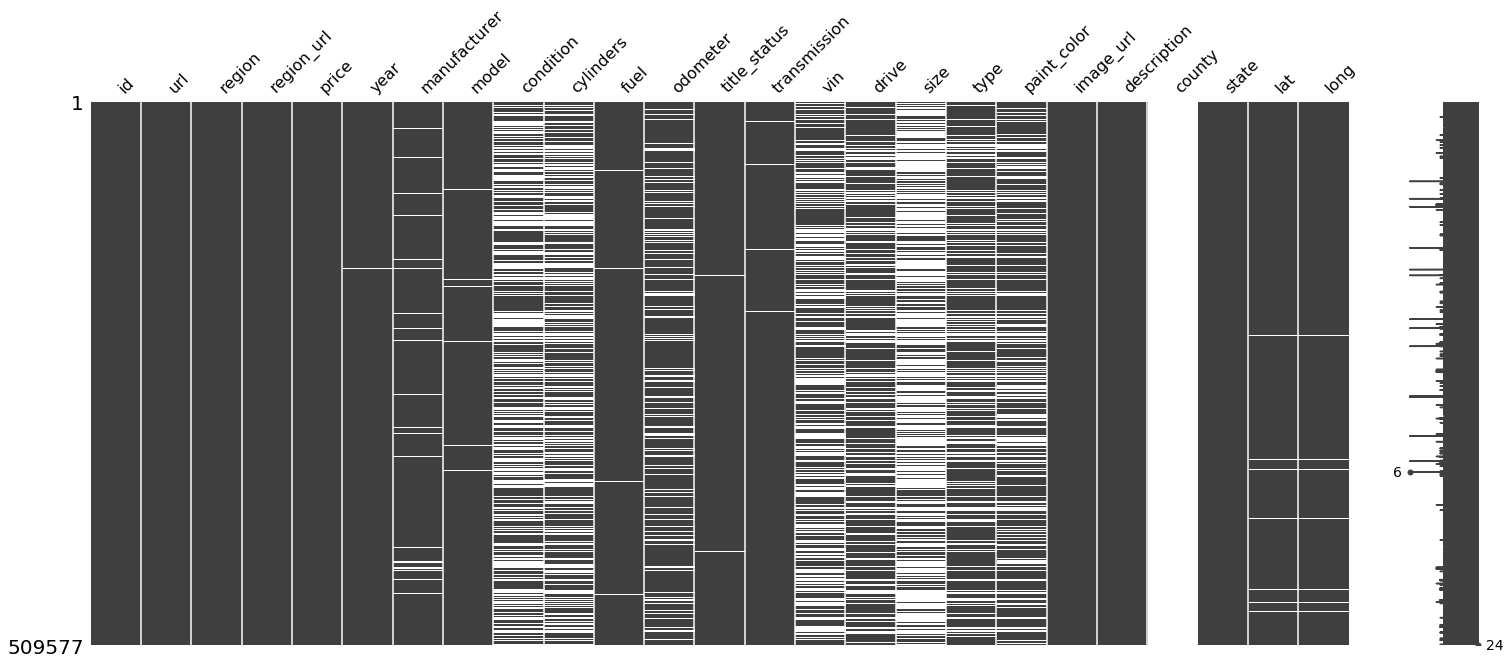

In [14]:
msno.matrix(df)
plt.show

We can see here that most of the columns have a large number of NAs, thus we can infer that this is a rather sparse dataset. We can also see that the column `county` has all NAs (509577/509577). As a result, I will be dropping this column.

##### Number of Unique Values in Each Column

In [15]:
df.nunique(axis = 0)

id              509577
url             509577
region             403
region_url         413
price            17854
year               114
manufacturer        43
model            35852
condition            6
cylinders            8
fuel                 5
odometer        119873
title_status         6
transmission         3
vin             180145
drive                3
size                 4
type                13
paint_color         12
image_url       349468
description     427803
county               0
state               51
lat              51488
long             51467
dtype: int64

We can see that the columns `id` and `url` has a unique value for each row. Due to the large numbers of unique values they have, I will be dropping them as well.
Following `id` and `url`, we can see that other categorical variables like `vin`, `image_url`, and `description` also have a large number of unique variables. As a result, I will be dropping these columns as well.

##### Analyzing Price Attribute

In [16]:
# Remove those rows which Price = 0
df = df[df.price != 0]

In [17]:
df['price'].describe()

count    4.659980e+05
mean     5.992131e+04
std      1.001272e+07
min      1.000000e+00
25%      5.000000e+03
50%      1.050000e+04
75%      1.895000e+04
max      3.600029e+09
Name: price, dtype: float64

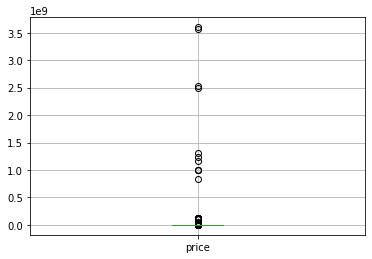

In [18]:
df.boxplot('price')

##### Relationship With Numerical Features

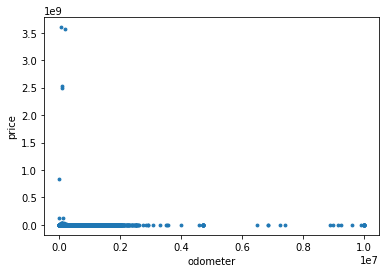

In [19]:
odo_price = pd.concat([df['price'], df['odometer']], axis = 1)
odo_price.plot.scatter(x = 'odometer', y = 'price', s = 8)

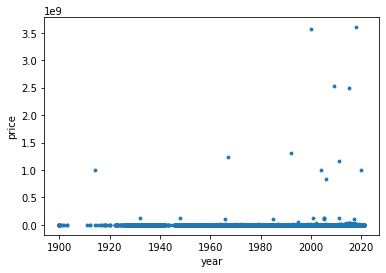

In [20]:
year_price = pd.concat([df['price'], df['year']], axis = 1)
year_price.plot.scatter(x = 'year', y = 'price', s = 8)

We can see that the above visualizations are not the best and most effecient way to visualize the distribution of price. 
As a result, I will be scaling both price to exlude the top 2% values and using a `boxplot` to visualize `price` vs. `year` of manufacture.

##### 1. Price vs. Odometer

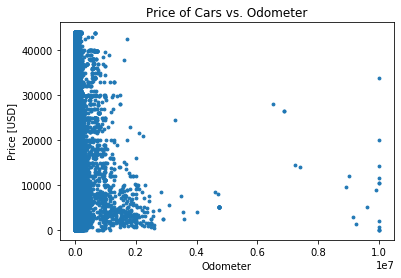

In [21]:
over_98_p = df["price"].quantile(.98)
df_plot = df[(df["price"] < over_98_p)]
odo_price = pd.concat([df_plot['price'], df_plot['odometer']], axis = 1)
odo_price.plot.scatter(x = 'odometer', y = 'price', s = 8)
plt.title("Price of Cars vs. Odometer")
plt.ylabel("Price [USD]")
plt.xlabel("Odometer");

Just by excluding cars with price that are in the top 2% did not seem to create a comprehensive visualization. As a result, I will attempt to exclude those with price in the top 1% and odometer in the top 1%.

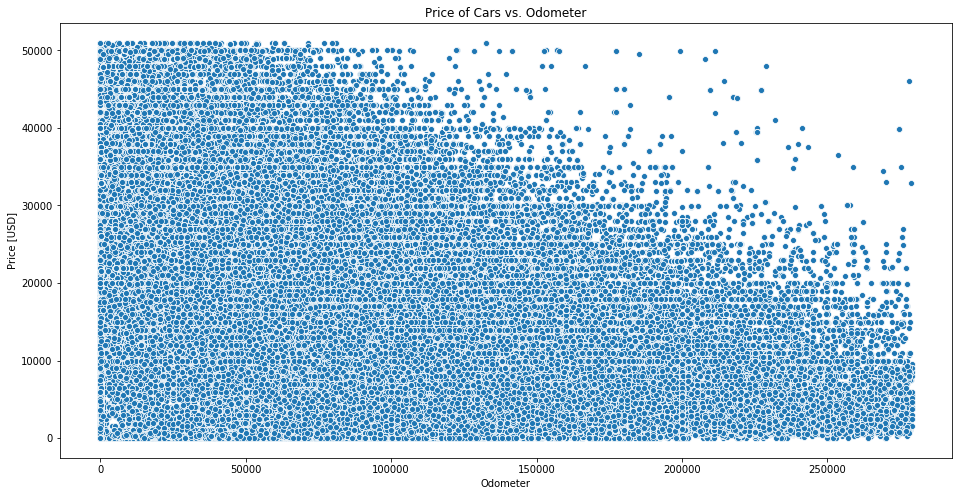

In [22]:
df_p_o = df[(df["odometer"] < df["odometer"].quantile(.99)) & ((df["price"] < df["price"].quantile(.99)))]
plt.figure(figsize = (16,8))
sns.scatterplot(x = 'odometer', y = 'price', data = df_p_o)
plt.title("Price of Cars vs. Odometer")
plt.ylabel("Price [USD]")
plt.xlabel("Odometer");

We can see from the `above visualization` that the lower the `odometer` on the car is, the more high `prices` there are. As a result, we can predict that `price` is negatively correlated with `odometer`.

##### 2. Price vs. Year of Manufacture

The plot below shows how the price of the cars listed changes with year of production.
As part of data cleaning, we will be excluding all cars with price 0 USD.

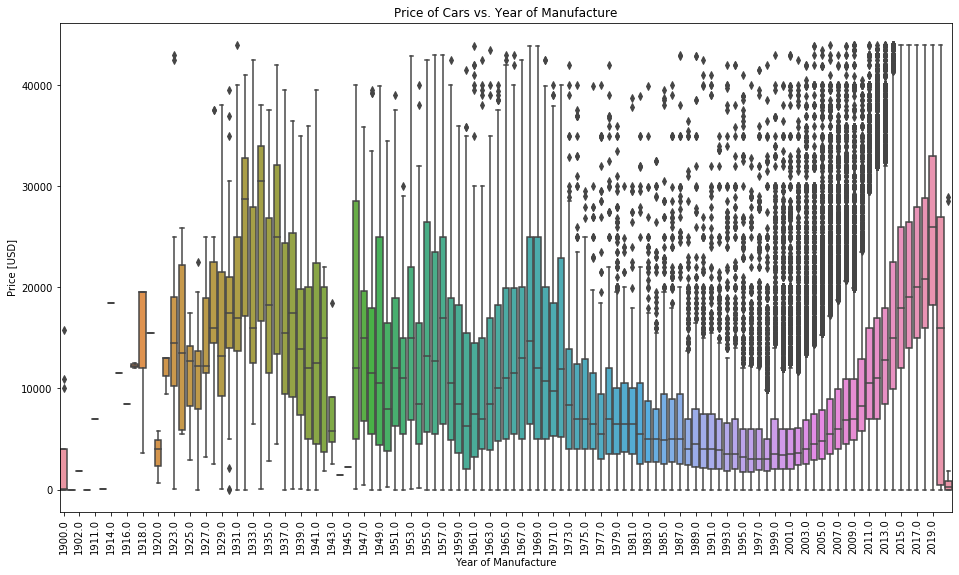

In [23]:
plt.figure(figsize = (16,9))
over_98 = df["price"].quantile(.98)
df_plot = df[(df["price"] < over_98)]
sns.boxplot(x = 'year', y = 'price', data = df_plot)
plt.title("Price of Cars vs. Year of Manufacture")
plt.ylabel("Price [USD]")
plt.xlabel("Year of Manufacture")

max_year = df_plot["year"].max()
min_year = df_plot["year"].min()
steps = 2
lab = np.sort(df_plot["year"].unique())[::2]
pos = np.arange(0,111,2)

plt.xticks(ticks = pos, labels = lab, rotation = 90)
plt.show()

We can see that the car's `year` of manufacture does affect its listed `price`.\
The cars with the lowest prices were manufactured between `1970` and `2000`. Whereas the cars with the highest prices were manufactured after `2015` and around the `1930s`.

In [24]:
# calculate correlation matrix
df.corr()

,id,price,year,odometer,county,lat,long
id,1.000000,-0.002523,-0.014401,-0.003881,NaN,-0.038500,-0.094658
price,-0.002523,1.000000,-0.004101,-0.000702,NaN,-0.000633,0.000991
year,-0.014401,-0.004101,1.000000,-0.260258,NaN,0.021634,-0.015328
odometer,-0.003881,-0.000702,-0.260258,1.000000,NaN,-0.008744,0.044103
county,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,-0.038500,-0.000633,0.021634,-0.008744,NaN,1.000000,-0.141697
long,-0.094658,0.000991,-0.015328,0.044103,NaN,-0.141697,1.000000


##### Relationship With Categorical Features

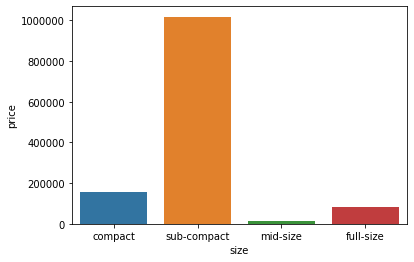

In [25]:
# Visualize relationship between size of the car and price (target)
size_price = sns.barplot(x= 'size', y = 'price', data = df, ci = None, 
                 order = ["compact", "sub-compact", "mid-size", "full-size"])

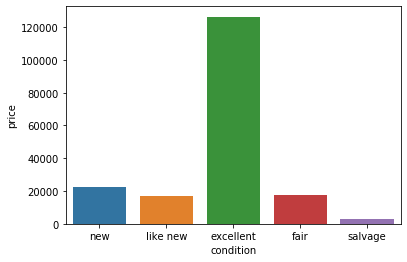

In [27]:
# Visualize relationship between condition and price (target)
condition_price = sns.barplot(x= 'condition', y = 'price', data = df, 
                              ci = None, order = ["new","like new","excellent","fair","salvage"])

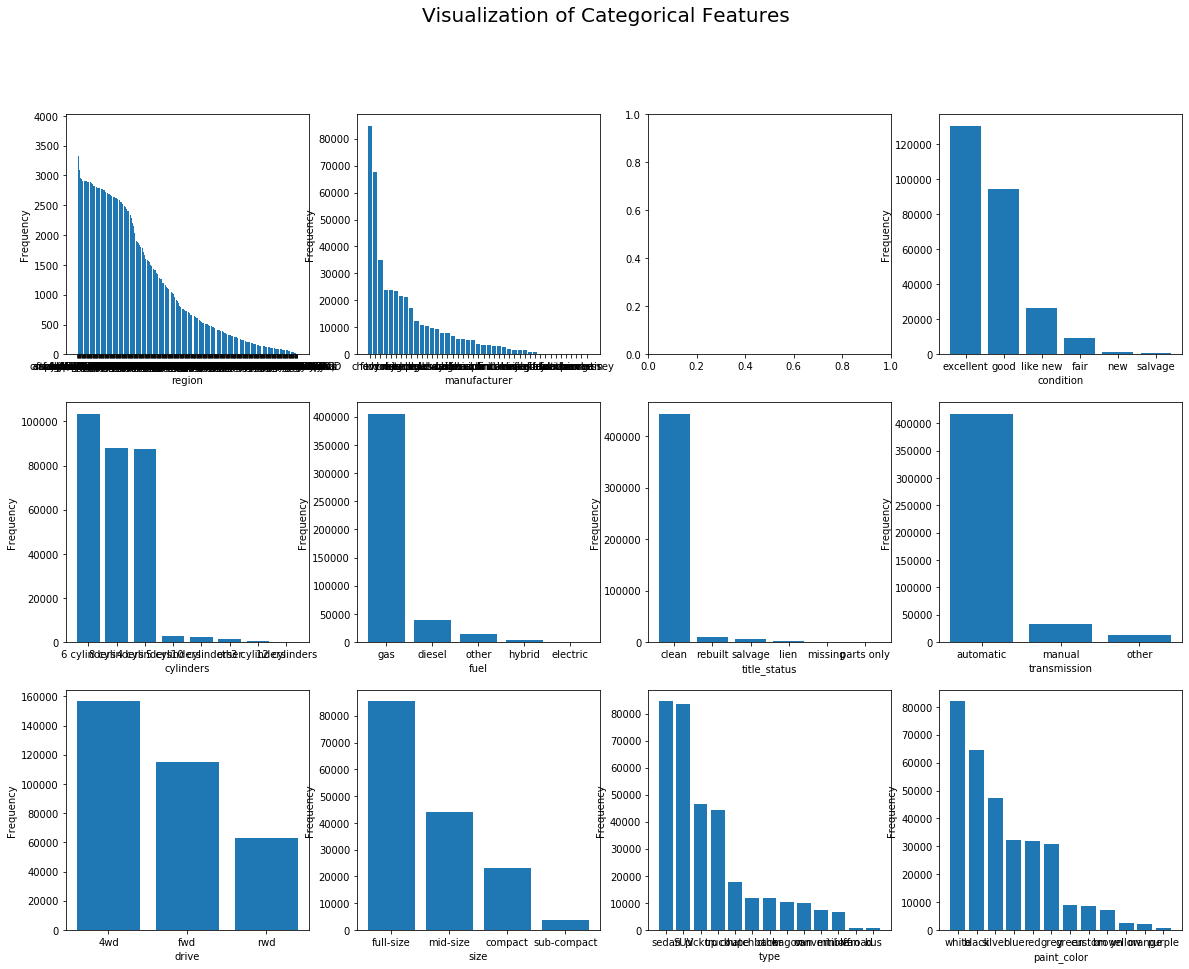

In [26]:
fig, ax = plt.subplots(3, 4, figsize = (20,15))
fig.suptitle('Visualization of All Categorical Features', fontsize = 20)

for row in range(len(ax)):
    for col in range(len(ax[0])):
        i = 4 * row + col
        if i < len(categorical_var) and categorical_var[i] != 'model':
            ax[row, col].bar(
            list(cars[categorical_var[i]].value_counts().axes[0]),
            list(cars[categorical_var[i]].value_counts().values)
            )
            ax[row, col].set_xlabel(categorical_var[i])
            ax[row, col].set_ylabel('Frequency')
plt.show()

##### Overall
**Target**: `price`

**Features**:
`region`,
`year`,
`manufacturer`,
`condition`,
`fuel`,
`odometer`,
`model`,
`title_status` (very imbalanced),
`transmission` (ver imbalanced),
`drive`,
`size`,
`type`,
`paint_color`,
`state`

**Removed Features**:
`id` (leaks information),
`url` (leaks information),
`region_url`,
`vin`,
`image_url`,
`description` (leaks information),
`county` (100% NaN),
`lat`,
`long`



## Preprocessing and Baseline Model

For this model, given the large amount of NAs present in this dataset, I will be dropping the NAs. However, this is definitely not the best way to preprocess data, thus this will only be used as a baseline for other models.

In [26]:
# Subsample 20% of data
cars_base = cars.sample(frac=0.2, replace=False, random_state=1)
cars_base = cars_base.dropna()
y = cars_base.price
X = cars_base.drop('price', axis = 1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.20, random_state=42)

In [23]:
continuous = ['year', 'odometer']

categorical = ['region', 'manufacturer', 'model', 'condition', 
               'cylinders', 'fuel', 'title_status', 'transmission', 
               'drive', 'size', 'type', 'paint_color', 'state']

continuous_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(handle_unknown='ignore'))

preprocessor = make_column_transformer(
        (continuous_transformer, continuous),
        (categorical_transformer, categorical))

In [24]:
lr_pip = make_pipeline(preprocessor, LinearRegression())
scores = np.mean(cross_val_score(lr_pip,X_train,y_train, scoring = "r2"))
print(f'mean cv accuracy using linear regression: {scores:0.8f}')

mean cv accuracy using linear regression: -8.98091818


In [25]:
rr_pip = make_pipeline(preprocessor, Ridge())
scores = np.mean(cross_val_score(rr_pip,X_train,y_train, scoring = "r2"))
print(f'mean cv accuracy using ridge regression: {scores:0.8f}')

mean cv accuracy using ridge regression: -5.40273739


## Feature Engineering
Create derived features and perform more in-depth preprocessing and data cleaning.\

#### Remove Outliers for Target 

In [27]:
# Remove unrealistice points before computing IQR
cars_filtered = cars[cars['price'].between(999, 250000)]

In [28]:
cars_filtered.describe()

,price,year,odometer
count,452229.000000,450720.000000,3.754120e+05
mean,14045.607035,2009.374144,1.041364e+05
std,11655.726830,8.639326,1.057170e+05
min,999.000000,1900.000000,0.000000e+00
25%,5680.000000,2006.000000,5.242675e+04
50%,10995.000000,2011.000000,9.750200e+04
75%,18998.000000,2015.000000,1.408320e+05
max,250000.000000,2021.000000,1.000000e+07


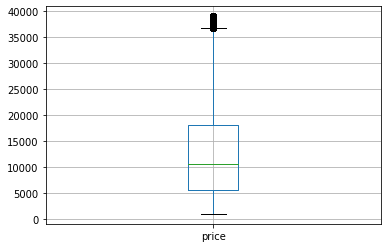

In [29]:
# Computing IQR for column: price
Q1 = cars_filtered['price'].quantile(0.25)
Q3 = cars_filtered['price'].quantile(0.75)
IQR = Q3 - Q1
cars_filtered = cars_filtered.query('(@Q1 - 1.5 * @IQR) <= price <= (@Q3 + 1.5 * @IQR)')
cars_filtered.boxplot('price')

#### Remove Outliers for Features

In [30]:
# Odometer
Q1 = cars_filtered['odometer'].quantile(0.25)
Q3 = cars_filtered['odometer'].quantile(0.75)
IQR = Q3 - Q1
filter_max = Q1 + 1.5*IQR
print(filter_max)

185363.25


In [31]:
cars_filtered = cars_filtered[cars_filtered['year'].between(1900.0, 2020.0)]
cars_filtered = cars_filtered[cars_filtered['odometer'].between(0.0, filter_max)]

In [20]:
cars_filtered.isna().sum()

region               0
price                0
year                 0
manufacturer      9190
model             2995
condition       134266
cylinders       111245
fuel              2799
odometer             0
title_status      2330
transmission      2726
drive            67892
size            212249
type             62011
paint_color      80286
state                0
dtype: int64

In [32]:
cars_filtered['year'] = cars_filtered.year.astype("int64")

In [33]:
# NEW SUBSAMPLE OF THE FILTERED DF
cars_filtered = cars_filtered.sample(frac=0.2, replace=False, random_state=1)
y_new = cars_filtered.price
X_new = cars_filtered.drop('price', axis = 1)

In [34]:
print(cars_filtered.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65425 entries, 93320 to 295129
Data columns (total 16 columns):
region          65425 non-null object
price           65425 non-null int64
year            65425 non-null int64
manufacturer    63622 non-null object
model           64781 non-null object
condition       38497 non-null object
cylinders       43233 non-null object
fuel            64869 non-null object
odometer        65425 non-null float64
title_status    64911 non-null object
transmission    64937 non-null object
drive           51668 non-null object
size            22961 non-null object
type            52968 non-null object
paint_color     49411 non-null object
state           65425 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 8.5+ MB
None


In [35]:
categorical = []
continuous = []
target_cat = []
for column in X_new.columns:
    if column == 'model' or column =='region':
        target_cat.append(column)
    elif cars_filtered[column].dtype == 'object':
        categorical.append(column)
    else:
        continuous.append(column)

In [36]:
print(f'categorical variables (one-hot-encoding): {categorical}')
print(f'categorical variables (target-encoding): {target_cat}')
print(f'continuous variables: {continuous}')

categorical variables (one-hot-encoding): ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']
categorical variables (target-encoding): ['region', 'model']
continuous variables: ['year', 'odometer']


In [37]:
# no PolynomialFeatures
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(handle_unknown='ignore'))

cat_target_transformer = make_pipeline(
    TargetEncoder())

# With PolynomialFeatures of Degree = 3
numeric_transformer_p = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    PolynomialFeatures(degree = 3, include_bias = False))

# I also tried Polynomial degree = 5, although the cv score is slightly better, 
# it takes much longer to run. Whereas 2 did not do as well as 5, as a result
# I settled for 3

# no PolynomialFeatures
preprocessor = make_column_transformer(
        (numeric_transformer, continuous),
        (categorical_transformer, categorical),
        (cat_target_transformer, target_cat)
        )
     
# With PolynomialFeatures
preprocessor_p = make_column_transformer(
        (numeric_transformer_p, continuous),
        (categorical_transformer, categorical),
        (cat_target_transformer, target_cat)
        )

#### Different Pipelines Using Different Regressors

##### Linear Regression

In [38]:
# Without PolynomialFeatures
lr_pip_2 = make_pipeline(preprocessor,LinearRegression())
# With PolynomialFeatures
lr_pip_3 = make_pipeline(preprocessor_p, LinearRegression())

##### Ridge Regression

In [39]:
# Without PolynomialFeatures
rr_pip_2 = make_pipeline(preprocessor, Ridge())
# With PolynomialFeatures
rr_pip_3 = make_pipeline(preprocessor_p, Ridge())

#### Training Scores

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y_new, test_size = 0.20, random_state=0)

In [41]:
scores = np.mean(cross_val_score(lr_pip_2,X_train,y_train, scoring='r2'))
print(f'mean cv accuracy using linear regression with preprocessing (no polynomial features): {scores:0.8f}')

mean cv accuracy using linear regression with preprocessing (no polynomial features): 0.69985482


- using only one hot (without subsampling): mean cv accuracy using linear regression: 0.76344017
- using one hot and target encoding (without subsampling): mean cv accuracy using linear regression: 0.72300240

In [43]:
scores = np.mean(cross_val_score(rr_pip_2, X_train, y_train, scoring = "r2"))
print(f'mean cv accuracy using ridge regressionwith preprocessing (no polynomial features): {scores:0.8f}')

mean cv accuracy using ridge regressionwith preprocessing (no polynomial features): 0.39248959


- using only one hot (without subsampling): mean cv accuracy using ridge regression: 0.77004001
- using one hot and target encoding (without subsampling): mean cv accuracy using ridge regression: 0.47184707

In [45]:
scores = np.mean(cross_val_score(lr_pip_3, X_train, y_train, scoring='r2'))
print(f'mean cv accuracy using linear regression with preprocessing and Polynomial Features (degree = 3): {scores:0.8f}')

mean cv accuracy using linear regression with preprocessing and Polynomial Features (degree = 3): 0.76233838


- mean cv accuracy using linear regression and Polynomial Features = 5 (without subsampling): 0.84084299
- mean cv accuracy using linear regression and Polynomial Features = 2 (without subsampling): 0.82423674

In [46]:
scores = np.mean(cross_val_score(rr_pip_3, X_train, y_train, scoring='r2'))
print(f'mean cv accuracy using ridge regression and Polynomial Features (degree = 3): {scores:0.8f}')

mean cv accuracy using ridge regression and Polynomial Features (degree = 3): 0.39248995


# Any model 
Use a regression model to improve your result. 

#### Different Pipelines Using Different Regressors

I will be using both `Decision Tree Regressor` and `Random Forest Regressor`. \
I will first be comparing the `average cross validation r2 scores` of the two `regressors` and then choose one to conduct `parameter tuning` on.

Upon doing some research on both `regressors`, I found that `Random Forest Regressor` requires minimum `preprocessing`, as it is very robust to `outliers`. 
For `Decision Tree Regressor`, it is recommended that `removal of outliers` is completed in the `preprocessing` steps, which I have done in `Task 3`.

As I will be `re-using` the same `df` from `Task 3`, we will use the same `preprocessing` steps for now.
However, I will also include further possible `preprocessing` steps that we can take towards the end of the task.

##### Decision Tree Regressor

In [47]:
dec_tree_pip = Pipeline([('preprocess', preprocessor_p),
                       ('regressor',DecisionTreeRegressor())])

In [50]:
score_tree = np.mean(cross_val_score(dec_tree_pip,X_train,y_train, scoring='r2'))

In [51]:
print(f'mean cv accuracy using decision tree regressor and Polynomial Features (degree = 3): {score_tree:0.8f}')

mean cv accuracy using decision tree regressor and Polynomial Features (degree = 3): 0.70117220


- average cv accuracy using decision tree regressor (polynomial features degree = 5): 0.8288284497795961

##### Random Forest Regressor

In [55]:
for_pip = make_pipeline(preprocessor_p, 
                       RandomForestRegressor())
score_for = np.mean(cross_val_score(for_pip,X_train,y_train, scoring='r2'))

In [57]:
print(f'mean cv accuracy using random forest regressor and Polynomial Features (degree = 3): {score_for:0.8f}')

mean cv accuracy using random forest regressor and Polynomial Features (degree = 3): 0.84241992


##### Parameter Tuning for Decision Tree Regressor

In [52]:
param_grid = dict(regressor__max_depth = [4,6,8,12])
grid = GridSearchCV(dec_tree_pip, param_grid, return_train_score = True)
grid.fit(X_train, y_train)
mean_score = np.mean(grid.score(X_train, y_train))

print(f'mean training gridsearch cv accuracy using decision tree: {mean_score:0.8f}')
print(grid.score(X_test, y_test))
print(grid.best_params_)

mean training gridsearch cv accuracy using decision tree: 0.86477893
0.7721133096579682
{'regressor__max_depth': 12}


- mean training gridsearch cv accuracy using decision tree regressor : 0.78735607
- {'regressor__criterion': 'mse', 'regressor__max_depth': 12}

#### Further Preprocessing

In [58]:
cat_new = []
con_new = []
target_new = ['model', 'region', 'manufacturer', 'state']
for column in X_new.columns:
    if column not in target_new:
        if cars_filtered[column].dtype == 'object':
            cat_new.append(column)
        else:
            con_new.append(column)

In [59]:
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(handle_unknown='ignore'))

cat_target_transformer = make_pipeline(
    TargetEncoder())

numeric_transformer_p = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    PolynomialFeatures(degree = 3, include_bias = False))

preprocessor_p = make_column_transformer(
        (numeric_transformer_p, con_new),
        (categorical_transformer, cat_new),
        (cat_target_transformer, target_new)
        )

In [60]:
dec_tree_pip_new = Pipeline([('preprocess', preprocessor_p),
                       ('regressor',DecisionTreeRegressor())])

In [61]:
score_tree = np.mean(cross_val_score(dec_tree_pip_new,X_train,y_train, scoring='r2'))

In [62]:
print(f'mean cv accuracy using decision tree regressor and Polynomial Features (degree = 3): {score_tree:0.8f}')

mean cv accuracy using decision tree regressor and Polynomial Features (degree = 3): 0.69123288


However, with further preprocessing (target encoding more categorical features), the model performance was not improved. As a result, I will be keeping our previous preprocessing steps.

## Feature Selections
Identify features that are important for the best model.

#### Generate Pipeline with Best Model

In [40]:
best_tree = make_pipeline(preprocessor_p, DecisionTreeRegressor(random_state = 0, max_depth = 12))
best_tree.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                             

##### Mean Cross Validation Score With Best Model

In [41]:
score_best_tree = np.mean(cross_val_score(best_tree, X_train, y_train))

In [42]:
print(score_best_tree)

0.7561963017134288


##### Test Score With Best Model

In [108]:
best_tree.score(X_test, y_test)

0.7684645926174534

#### Get Feature Names of the Preprocessed Features

In [59]:
column_transformer = best_tree.steps[0][-1]
con_features = column_transformer.transformers_[0][1].steps[-1][-1].get_feature_names()
onehot_cat = column_transformer.transformers_[1][1].steps[-1][-1].get_feature_names()
target_cat = column_transformer.transformers_[2][-1]
print('Target Encoded Features:', target_cat)
print('\nOne Hot Encoded Categorical Features:', onehot_cat)
print('\nContinuous (Polynomial) Features:', con_features)
print('\nTotal:', len(con_features) + len(onehot_cat) + len(target_cat))

Target Encoded Features: ['region', 'model']

One Hot Encoded Categorical Features: ['x0_acura' 'x0_alfa-romeo' 'x0_aston-martin' 'x0_audi' 'x0_bmw'
 'x0_buick' 'x0_cadillac' 'x0_chevrolet' 'x0_chrysler' 'x0_datsun'
 'x0_dodge' 'x0_fiat' 'x0_ford' 'x0_gmc' 'x0_harley-davidson' 'x0_honda'
 'x0_hyundai' 'x0_infiniti' 'x0_jaguar' 'x0_jeep' 'x0_kia' 'x0_land rover'
 'x0_lexus' 'x0_lincoln' 'x0_mazda' 'x0_mercedes-benz' 'x0_mercury'
 'x0_mini' 'x0_missing' 'x0_mitsubishi' 'x0_nissan' 'x0_pontiac' 'x0_ram'
 'x0_rover' 'x0_saturn' 'x0_subaru' 'x0_tesla' 'x0_toyota' 'x0_volkswagen'
 'x0_volvo' 'x1_excellent' 'x1_fair' 'x1_good' 'x1_like new' 'x1_missing'
 'x1_new' 'x1_salvage' 'x2_10 cylinders' 'x2_12 cylinders'
 'x2_3 cylinders' 'x2_4 cylinders' 'x2_5 cylinders' 'x2_6 cylinders'
 'x2_8 cylinders' 'x2_missing' 'x2_other' 'x3_diesel' 'x3_electric'
 'x3_gas' 'x3_hybrid' 'x3_missing' 'x3_other' 'x4_clean' 'x4_lien'
 'x4_missing' 'x4_parts only' 'x4_rebuilt' 'x4_salvage' 'x5_automatic'
 'x5_manual

In [63]:
all_column_names = np.array(list(con_features) + list(onehot_cat) + list(target_cat))

#### Get Feature Importance From Best Model

In [60]:
feature_importance = grid.best_estimator_.steps[-1][-1].feature_importances_

In [62]:
best_feature = np.argpartition(abs(feature_importance), -15)[-15:]

In [61]:
print(len(feature_importance))

170


Text(0.5, 0, 'Log Reg Coefficients')

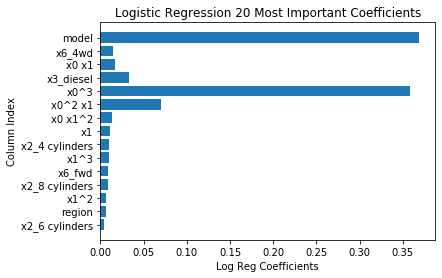

In [64]:
ax = plt.barh(all_column_names[best_feature], feature_importance[best_feature])
plt.title('Logistic Regression 15 Most Important Coefficients')
plt.ylabel('Column Index')
plt.xlabel('Log Reg Coefficients')

**We can see that the `three` most important features are: `model`, `x0^3` (Polynomial Feature), and `x0^2 x1` (Polynomial feature).**

##### Feature Selection (Select Features Better than the Median)

In [91]:
select = SelectFromModel(
    DecisionTreeRegressor(max_depth = 12, random_state = 0 ),
    threshold="median")

In [92]:
feature_select_pip = make_pipeline(preprocessor_p, select)

In [95]:
feature_select_pip.fit(X_train, y_train)
X_train_l1 = feature_select_pip.transform(X_train)
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train_l1.shape: (52340, 85)


In [106]:
pipe_select = make_pipeline(feature_select_pip, DecisionTreeRegressor())
score = np.mean(cross_val_score(pipe_select, X_train, y_train, scoring = 'r2'))

In [107]:
print(score)

0.6993094941538629


Contrary to what was expected, removing features that are worse than the `median` did not improve our model. However, it also did not make our model significantly worse.

I hypothesize that instead of removing half of the features, if I had only removed the irrelevant ones, my model would perform better.

However, since I have performed excess preprocessing and removed any features that can be irrelevant, there is a chance that removing anymore would not necessarily improve the current model

## An explainable model
aim: should be small enough to be easily inspected - say a linear model with few enough coefficients 

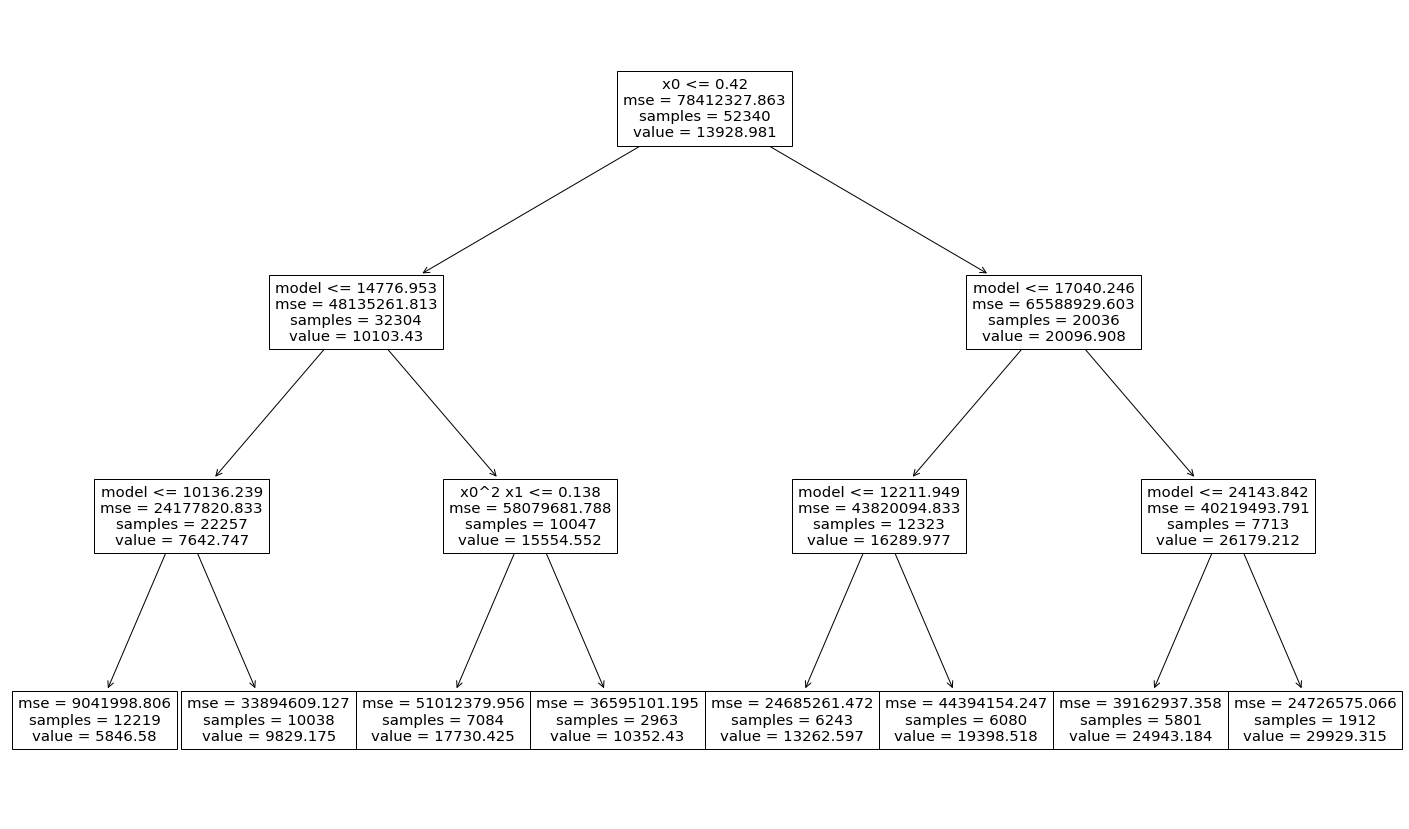

In [86]:
from sklearn.tree import plot_tree
explainable_tree = make_pipeline(preprocessor_p, DecisionTreeRegressor(random_state = 0, max_depth = 3))
explainable_tree.fit(X_train, y_train)
plt.figure(figsize = (25, 15))
tree_dot = plot_tree(explainable_tree.steps[-1][-1], feature_names = all_column_names)

#### Summary of Cross-Validation Scores

**Linear Regression**: 0.76

**Ridge Regression**: 0.39

**Decision Tree Regression**: 0.70

**Random Forest Regression**: 0.84


Taking all into consideration (model performance, training score, test score, running time etcs.), I decided to perform parameter tuning on **Decision Tree Regressor**.

I found that the best `max_depth` to use is `max_depth = 12`.\
The mean cross validation score obtained using `max_depth = 12` is `0.86477893`,\
and the `test score` obtained is `0.7721133096579682`.

Upon performing `feature selection` and choosing only features that are better than the `median` feature importance, our model performance was not improved much. I suspect that this is due to the extensive `preprocessing` performed.

To construct `an explainable model`, I decided to contruct a tree with `max_depth = 3`.